In [1]:
from sqlalchemy import create_engine,text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credentials = "cre.json"#put this file in the same dir of ipynb & data

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host = db_conn_dict['host']
        db_user = db_conn_dict['user']
        db_pw = db_conn_dict['password']
        default_db = db_conn_dict['user']
    try:
        db = create_engine('postgresql+psycopg2://' + db_user + ':' + db_pw + '@' + host + '/' + default_db, echo=False)
        conn = db.connect()
        print('Connected successfully.')
    except Exception as e:
        print("Unable to connect to the database.")
        print(e)
        db, conn = None, None
    return db, conn

In [3]:
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [4]:
db, conn = pgconnect(credentials)

Connected successfully.


In [5]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# Task1

## SA2

In [6]:
sa2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

In [7]:
#Data Cleaning
sa2.dropna(subset=['geometry'], inplace=True)
sa2 = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']
columns_to_keep = ['SA2_CODE21', 'SA2_NAME21','geometry']
sa2 = sa2[columns_to_keep]
sa2.columns = [col.lower() for col in sa2.columns]
sa2.rename(columns={'sa2_code21': 'sa2_code', 'sa2_name21': 'sa2_name'}, inplace=True)
sa2

,sa2_code,sa2_name,geometry
28,102011028,Avoca Beach - Copacabana,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...
637,128021537,Royal National Park,"POLYGON ((151.07363 -34.05638, 151.07360 -34.0..."
638,128021538,Sutherland - Kirrawee,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
639,128021607,Engadine,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
640,128021608,Loftus - Yarrawarrah,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


In [8]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2 = sa2.drop(columns='geometry')
sa2

,sa2_code,sa2_name,geom
28,102011028,Avoca Beach - Copacabana,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...
637,128021537,Royal National Park,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,MULTIPOLYGON (((151.03954821100714 -34.0417452...


In [9]:
sql_command = text("""
DROP TABLE IF EXISTS sa2 CASCADE;
CREATE TABLE sa2 (
    sa2_code VARCHAR(50), 
    sa2_name VARCHAR(80), 
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)
conn.execute(sql_command)
sa2.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,sa2_code,sa2_name,geom
0,102011028,Avoca Beach - Copacabana,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020BB100000010000000103000000010000007E...
...,...,...,...
368,128021537,Royal National Park,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0106000020BB10000001000000010300000001000000A1...


## Population

In [10]:
pop = pd.read_csv("Population.csv")

In [11]:
young_cols = ['0-4_people', '5-9_people', '10-14_people', '15-19_people']
middle_cols = ['20-24_people', '25-29_people', '30-34_people', '35-39_people', '40-44_people', 
               '45-49_people', '50-54_people', '55-59_people', '60-64_people']
senior_cols = ['65-69_people', '70-74_people', '75-79_people', '80-84_people', '85-and-over_people']
pop['young'] = pop[young_cols].sum(axis=1)
pop['middle_aged'] = pop[middle_cols].sum(axis=1)
pop['senior'] = pop[senior_cols].sum(axis=1)
print(pop[['sa2_name', 'young', 'middle_aged', 'senior']])

                        sa2_name  young  middle_aged  senior
0       Avoca Beach - Copacabana   2121         4138    1271
1    Box Head - MacMasters Beach   2471         5595    2986
2                Calga - Kulnura    961         2831     956
3            Erina - Green Point   3205         6839    4759
4          Gosford - Springfield   4364        13190    3792
..                           ...    ...          ...     ...
368          Royal National Park     20           24       1
369        Sutherland - Kirrawee   5078        14303    3988
370                     Engadine   5118         9204    3057
371         Loftus - Yarrawarrah   2073         3964    1317
372             Woronora Heights    965         2100     486

[373 rows x 4 columns]


In [12]:
pop = pop.drop(columns=young_cols + middle_cols + senior_cols) #use this if neeeded

In [13]:
sql_commands = text("""
DROP TABLE IF EXISTS pop CASCADE;
CREATE TABLE pop (
    sa2_code VARCHAR(50),
    sa2_name VARCHAR(150),
    total_people INTEGER,
    young INTEGER,
    middle_aged INTEGER,
    senior INTEGER
);    
""")
conn.execute(sql_commands)

In [14]:
pop.to_sql('pop', conn, if_exists='append', index=False)
query(conn, "select * from pop")

,sa2_code,sa2_name,total_people,young,middle_aged,senior
0,102011028,Avoca Beach - Copacabana,7530,2121,4138,1271
1,102011029,Box Head - MacMasters Beach,11052,2471,5595,2986
2,102011030,Calga - Kulnura,4748,961,2831,956
3,102011031,Erina - Green Point,14803,3205,6839,4759
4,102011032,Gosford - Springfield,21346,4364,13190,3792
...,...,...,...,...,...,...
368,128021537,Royal National Park,45,20,24,1
369,128021538,Sutherland - Kirrawee,23369,5078,14303,3988
370,128021607,Engadine,17379,5118,9204,3057
371,128021608,Loftus - Yarrawarrah,7354,2073,3964,1317


## Stops

In [15]:
stopp = pd.read_csv("Stops.txt", sep=",")

In [16]:
stopp.columns = map(str.lower, stopp.columns)
stopp = stopp.drop(columns=["stop_code"])
stopp = stopp.dropna(subset=["stop_lat", "stop_lon", "platform_code"])
stopp['stop_lat'] = pd.to_numeric(stopp['stop_lat'])
stopp['stop_lon'] = pd.to_numeric(stopp['stop_lon'])
stopp['location_type'] = pd.to_numeric(stopp['location_type'], errors='coerce').astype('Int64')
stopp['wheelchair_boarding'] = stopp['wheelchair_boarding'].replace('unknown', False)
stopp['wheelchair_boarding'] = stopp['wheelchair_boarding'].astype(bool)
stopp['geom'] = gpd.points_from_xy(stopp.stop_lon, stopp.stop_lat)

In [17]:
stopp['geom'] = gpd.points_from_xy(stopp.stop_lon, stopp.stop_lat)
stopp = stopp.drop(columns=['stop_lat', 'stop_lon','location_type'])
stopp['geom'] = stopp['geom'].apply(lambda x: WKTElement(x.wkt, srid)) 
stopp

,stop_id,stop_name,parent_station,wheelchair_boarding,platform_code,geom
268,2000321,"Central Station, Platform 1",200060,True,1,POINT (151.205857239232 -33.8827026104032)
269,2000322,"Central Station, Platform 2",200060,True,2,POINT (151.206010876138 -33.8827514159554)
270,2000323,"Central Station, Platform 3",200060,True,3,POINT (151.206065683333 -33.8827675614993)
271,2000324,"Central Station, Platform 4",200060,True,4,POINT (151.205833824408 -33.8833250903178)
272,2000325,"Central Station, Platform 5",200060,True,5,POINT (151.205878289466 -33.8833505994121)
...,...,...,...,...,...,...
114705,211033,"Cockatoo Island Wharf, Side A",20009,True,A,POINT (151.173472310664 -33.8455132071555)
114712,212751,"Sydney Olympic Park Wharf, Side A",21271,True,A,POINT (151.078826747355 -33.82196140981)
114713,212753,"Sydney Olympic Park Wharf, Side B",21271,True,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,"Cabarita Wharf, Side A",21371,True,1A,POINT (151.116926480557 -33.8406690716775)


In [18]:
sql_commands = text("""
DROP TABLE IF EXISTS stopp CASCADE;
CREATE TABLE stopp(
    stop_id VARCHAR(50) PRIMARY KEY,
    stop_name VARCHAR(150),
    parent_station VARCHAR(50),
    wheelchair_boarding BOOLEAN,
    platform_code VARCHAR(50),
    geom GEOMETRY(POINT, 4283)
);
""")
conn.execute(sql_commands)
stopp.to_sql("stopp", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

871

## Polls

In [19]:
pollp = pd.read_csv("PollingPlaces2019.csv")

In [20]:
pollp['premises_post_code'] = pollp['premises_post_code'].fillna(0).astype(int)
pollp['premises_post_code'] = pollp['premises_post_code'].astype(str)
pollp['premises_post_code'] = pollp['premises_post_code'].replace('0', 'unknown')

In [21]:
pollp['full_address'] = pollp['premises_address_1'].fillna('') + ' ' + pollp['premises_address_2'].fillna('') + ' ' + pollp['premises_address_3'].fillna('')
pollp['full_address'] = pollp['full_address'].str.strip()
pollp.drop(['premises_address_1', 'premises_address_2', 'premises_address_3'], axis=1, inplace=True)
pollp.columns = [col.lower() for col in pollp.columns]
pollp.dropna(inplace=True)
pollp

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom,full_address
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,OATLEY,NSW,2223,-33.984700,151.081000,POINT (-33.9847 151.081),51 Letitia St
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,DHARRUK,NSW,2770,-33.747500,150.817000,POINT (-33.7475 150.817),7 Stuart Rd
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,ALLAWAH,NSW,2218,-33.976790,151.114897,POINT (-33.9767897 151.1148974),147B Bellevue Pde
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,SOUTH HURSTVILLE,NSW,2221,-33.975600,151.111000,POINT (-33.9756 151.111),84 George St
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,BEVERLY HILLS,NSW,2209,-33.941300,151.075000,POINT (-33.9413 151.075),1-3 Shorter Ave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,WARILLA,NSW,2528,-34.547240,150.851770,POINT (-34.54724 150.85177),2-6 Hill St
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,NSW,2528,-34.564200,150.858000,POINT (-34.5642 150.858),10 Keross Ave
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,NSW,2528,-34.550823,150.859755,POINT (-34.5508228 150.8597546),
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,NSW,2575,-34.440900,150.424000,POINT (-34.4409 150.424),14 Currockbilly St


In [22]:
pollp['geom'] = gpd.points_from_xy(pollp.longitude, pollp.latitude)
pollp.drop(columns=['latitude', 'longitude', 'the_geom'],inplace=True)
pollp['geom'] = pollp['geom'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
pollp

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_state_abbreviation,premises_post_code,full_address,geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,OATLEY,NSW,2223,51 Letitia St,POINT (151.081 -33.9847)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,DHARRUK,NSW,2770,7 Stuart Rd,POINT (150.817 -33.7475)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,ALLAWAH,NSW,2218,147B Bellevue Pde,POINT (151.1148974 -33.9767897)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,SOUTH HURSTVILLE,NSW,2221,84 George St,POINT (151.111 -33.9756)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,BEVERLY HILLS,NSW,2209,1-3 Shorter Ave,POINT (151.075 -33.9413)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,WARILLA,NSW,2528,2-6 Hill St,POINT (150.85177 -34.54724)
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,NSW,2528,10 Keross Ave,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,NSW,2528,,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,NSW,2575,14 Currockbilly St,POINT (150.424 -34.4409)


In [23]:
sql_commands = text("""DROP TABLE IF EXISTS pollp CASCADE;
CREATE TABLE pollp (
    fid VARCHAR(100),
    state VARCHAR(50),
    division_id INTEGER,
    division_name VARCHAR(150),
    polling_place_id INTEGER,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(150),
    premises_name VARCHAR(150),
    premises_suburb VARCHAR(150),
    premises_state_abbreviation VARCHAR(50),
    premises_post_code VARCHAR(50),
    geom GEOMETRY(POINT, 4283), 
    full_address VARCHAR(255)
);
""")
conn.execute(sql_commands)
pollp.to_sql('pollp', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
sql = text("""select * from Pollp;""")
query(conn, sql)

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_state_abbreviation,premises_post_code,geom,full_address
0,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,OATLEY,NSW,2223,0101000020BB1000003BDF4F8D97E26240832F4CA60AFE...,51 Letitia St
1,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,DHARRUK,NSW,2770,0101000020BB100000A01A2FDD24DA624048E17A14AEDF...,7 Stuart Rd
2,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,ALLAWAH,NSW,2218,0101000020BB100000A7EC4F3DADE36240EA48E47107FD...,147B Bellevue Pde
3,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,SOUTH HURSTVILLE,NSW,2221,0101000020BB100000643BDF4F8DE3624022FDF675E0FC...,84 George St
4,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,BEVERLY HILLS,NSW,2209,0101000020BB1000006666666666E26240C6DCB5847CF8...,1-3 Shorter Ave
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,WARILLA,NSW,2528,0101000020BB100000D8B628B341DB62401288D7F50B46...,2-6 Hill St
2786,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,NSW,2528,0101000020BB100000FA7E6ABC74DB62409C33A2B43748...,10 Keross Ave
2787,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,NSW,2528,0101000020BB100000BD32141C83DB624011F28B5C8146...,
2788,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,NSW,2575,0101000020BB10000021B0726891CD6240386744696F38...,14 Currockbilly St


## Income

In [24]:
incom = pd.read_csv("Income.csv")

In [25]:
incom.rename(columns={'sa2_code21': 'sa2_code'}, inplace=True)
incom = incom[incom['earners'] != 'np']
incom['earners'] = incom['earners'].astype(int)
incom['median_age'] = incom['median_age'].astype(int)
incom['median_income'] = incom['median_income'].astype(int)
incom['mean_income'] = incom['mean_income'].astype(int)
incom

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


In [26]:
sql_commands = text("""DROP TABLE IF EXISTS Incom CASCADE;
CREATE TABLE Incom (
    sa2_code VARCHAR(50),
    sa2_name VARCHAR(150),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);""")
conn.execute(sql_commands)
incom.to_sql('incom', conn, if_exists='append', index=False)

635

## Business

In [27]:
buss = pd.read_csv("Businesses.csv")
buss

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [28]:

buss['low_revenue'] = buss['0_to_50k_businesses'] + buss['50k_to_200k_businesses']
buss['medium_revenue'] = buss['200k_to_2m_businesses'] + buss['2m_to_5m_businesses']
buss['high_revenue'] = buss['5m_to_10m_businesses'] + buss['10m_or_more_businesses']
buss['prop_low_revenue'] = round((buss['low_revenue'] / buss['total_businesses']) * 100, 2)
buss['prop_medium_revenue'] = round((buss['medium_revenue'] / buss['total_businesses']) * 100, 2)
buss['prop_high_revenue'] = round((buss['high_revenue'] / buss['total_businesses']) * 100, 2)

#buss = buss[buss['prop_high_revenue'] > 20]

In [29]:
buss.dropna(subset=['prop_low_revenue', 'prop_medium_revenue', 'prop_high_revenue'], inplace=True)
buss.drop(columns=['0_to_50k_businesses', '50k_to_200k_businesses', '200k_to_2m_businesses',
                   '2m_to_5m_businesses', '5m_to_10m_businesses', '10m_or_more_businesses'], inplace=True)
buss

,industry_code,industry_name,sa2_code,sa2_name,total_businesses,low_revenue,medium_revenue,high_revenue,prop_low_revenue,prop_medium_revenue,prop_high_revenue
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,296,228,67,0,77.03,22.64,0.00
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9,0,0,100.00,0.00,0.00
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15,10,3,3,66.67,20.00,20.00
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3,0,0,100.00,0.00,0.00
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,11,5,0,68.75,31.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,152,87,61,3,57.24,40.13,1.97
12213,S,Other Services,128021607,Engadine,87,54,34,0,62.07,39.08,0.00
12214,S,Other Services,128021608,Loftus - Yarrawarrah,22,10,10,0,45.45,45.45,0.00
12215,S,Other Services,128021609,Woronora Heights,9,3,5,0,33.33,55.56,0.00


In [30]:
sql_commands = text("""DROP TABLE IF EXISTS Buss CASCADE;
CREATE TABLE Buss (
    industry_code VARCHAR(10),
    industry_name VARCHAR(150),
    sa2_code VARCHAR(50),
    sa2_name VARCHAR(150),
    total_businesses INTEGER,
    low_revenue INTEGER,
    medium_revenue INTEGER,
    high_revenue INTEGER,
    prop_low_revenue FLOAT,
    prop_medium_revenue FLOAT,
    prop_high_revenue FLOAT
);""")

conn.execute(sql_commands)
buss.to_sql('buss', conn, if_exists='append', index=False)
sql = text("""SELECT * FROM Buss;""")
query(conn, sql)

,industry_code,industry_name,sa2_code,sa2_name,total_businesses,low_revenue,medium_revenue,high_revenue,prop_low_revenue,prop_medium_revenue,prop_high_revenue
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,296,228,67,0,77.03,22.64,0.00
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9,0,0,100.00,0.00,0.00
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15,10,3,3,66.67,20.00,20.00
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3,0,0,100.00,0.00,0.00
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,11,5,0,68.75,31.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...
11159,S,Other Services,128021538,Sutherland - Kirrawee,152,87,61,3,57.24,40.13,1.97
11160,S,Other Services,128021607,Engadine,87,54,34,0,62.07,39.08,0.00
11161,S,Other Services,128021608,Loftus - Yarrawarrah,22,10,10,0,45.45,45.45,0.00
11162,S,Other Services,128021609,Woronora Heights,9,3,5,0,33.33,55.56,0.00


## Schools

In [31]:
future = gpd.read_file("catchments/catchments_future.shp")
primary = gpd.read_file("catchments/catchments_primary.shp")
secondary = gpd.read_file("catchments/catchments_secondary.shp")
columns_to_keep = ['USE_ID', 'CATCH_TYPE', 'USE_DESC','geometry']
future = future[columns_to_keep]
primary = primary[columns_to_keep]
secondary = secondary[columns_to_keep]
school = gpd.GeoDataFrame(pd.concat([future, primary, secondary], ignore_index=True))
school.columns = [col.lower() for col in school.columns]
school

,use_id,catch_type,use_desc,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."
...,...,...,...,...
2123,8213,HIGH_BOYS,Birrong BHS,"POLYGON ((151.05364 -33.85076, 151.06142 -33.8..."
2124,8108,HIGH_COED,Cessnock HS,"POLYGON ((151.42852 -32.74415, 151.43080 -32.7..."
2125,3235,CENTRAL_HIGH,Tooleybuc CS,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
2126,1115,CENTRAL_HIGH,Balranald CS,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


In [32]:
school['geom'] = school['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school = school.drop(columns='geometry')
school

,use_id,catch_type,use_desc,geom
0,8416,HIGH_COED,Ku-ring-gai HS,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,MULTIPOLYGON (((151.28072275958445 -33.8328728...
...,...,...,...,...
2123,8213,HIGH_BOYS,Birrong BHS,MULTIPOLYGON (((151.05363508494244 -33.8507612...
2124,8108,HIGH_COED,Cessnock HS,MULTIPOLYGON (((151.4285214252146 -32.74415247...
2125,3235,CENTRAL_HIGH,Tooleybuc CS,MULTIPOLYGON (((143.37723402388323 -34.8017260...
2126,1115,CENTRAL_HIGH,Balranald CS,MULTIPOLYGON (((143.65540852703225 -33.5570248...


In [33]:
sql_command = text("""
DROP TABLE IF EXISTS school;
CREATE TABLE school (
    use_id NUMERIC,
    catch_type VARCHAR(80),
    use_desc VARCHAR(80),
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)
conn.execute(sql_command)
school.to_sql("school", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from school")

,use_id,catch_type,use_desc,geom
0,8416.0,HIGH_COED,Ku-ring-gai HS,0106000020BB1000000100000001030000000100000090...
1,8161.0,HIGH_BOYS,Randwick BHS,0106000020BB100000010000000103000000010000006F...
2,1498.0,PRIMARY,Brisbania PS,0106000020BB100000010000000103000000010000001F...
3,1659.0,PRIMARY,Corowa SPS,0106000020BB1000000100000001030000000100000007...
4,3867.0,PRIMARY,Lake Illawarra SPS,0106000020BB1000000100000001030000000100000022...
...,...,...,...,...
2123,8213.0,HIGH_BOYS,Birrong BHS,0106000020BB1000000100000001030000000100000040...
2124,8108.0,HIGH_COED,Cessnock HS,0106000020BB10000001000000010300000001000000AD...
2125,3235.0,CENTRAL_HIGH,Tooleybuc CS,0106000020BB100000010000000103000000010000003E...
2126,1115.0,CENTRAL_HIGH,Balranald CS,0106000020BB100000010000000103000000010000005B...


In [34]:
sql = text("""select * from buss;""")
query(conn, sql)

,industry_code,industry_name,sa2_code,sa2_name,total_businesses,low_revenue,medium_revenue,high_revenue,prop_low_revenue,prop_medium_revenue,prop_high_revenue
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,296,228,67,0,77.03,22.64,0.00
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9,0,0,100.00,0.00,0.00
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15,10,3,3,66.67,20.00,20.00
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3,0,0,100.00,0.00,0.00
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,11,5,0,68.75,31.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...
11159,S,Other Services,128021538,Sutherland - Kirrawee,152,87,61,3,57.24,40.13,1.97
11160,S,Other Services,128021607,Engadine,87,54,34,0,62.07,39.08,0.00
11161,S,Other Services,128021608,Loftus - Yarrawarrah,22,10,10,0,45.45,45.45,0.00
11162,S,Other Services,128021609,Woronora Heights,9,3,5,0,33.33,55.56,0.00


In [35]:
sql = text("""select * from pop;""")
query(conn, sql)

,sa2_code,sa2_name,total_people,young,middle_aged,senior
0,102011028,Avoca Beach - Copacabana,7530,2121,4138,1271
1,102011029,Box Head - MacMasters Beach,11052,2471,5595,2986
2,102011030,Calga - Kulnura,4748,961,2831,956
3,102011031,Erina - Green Point,14803,3205,6839,4759
4,102011032,Gosford - Springfield,21346,4364,13190,3792
...,...,...,...,...,...,...
368,128021537,Royal National Park,45,20,24,1
369,128021538,Sutherland - Kirrawee,23369,5078,14303,3988
370,128021607,Engadine,17379,5118,9204,3057
371,128021608,Loftus - Yarrawarrah,7354,2073,3964,1317


# Task2

## Business z-score

In [36]:
sql_command = text(
 """
CREATE VIEW retail_business_per_1000 AS
SELECT
    b.sa2_code,
    b.sa2_name,
    b.industry_code,
    b.industry_name,
    b.total_businesses,
    p.total_people,
    (b.total_businesses::float / p.total_people) * 1000 AS business_per_1000
FROM
    Buss b
JOIN
    Pop p
ON
    b.sa2_code = p.sa2_code
WHERE
    b.industry_name = 'Retail Trade';

CREATE VIEW retail_business_stats AS
SELECT
    AVG(business_per_1000) AS mean_business_per_1000,
    STDDEV(business_per_1000) AS stddev_business_per_1000
FROM
    retail_business_per_1000;

CREATE VIEW retail_business_z_score AS
SELECT
    b.sa2_code,
    b.sa2_name,
    b.business_per_1000,
    (b.business_per_1000 - s.mean_business_per_1000) / s.stddev_business_per_1000 AS z_business
FROM
    retail_business_per_1000 b,
    retail_business_stats s;
"""
)
conn.execute(sql_command)
sql = text("""SELECT * FROM retail_business_z_score; """)
query(conn, sql)

,sa2_code,sa2_name,business_per_1000,z_business
0,102011028,Avoca Beach - Copacabana,5.976096,-0.111107
1,102011029,Box Head - MacMasters Beach,4.524068,-0.116847
2,102011030,Calga - Kulnura,12.005055,-0.087273
3,102011031,Erina - Green Point,10.268189,-0.094139
4,102011032,Gosford - Springfield,8.432493,-0.101396
...,...,...,...,...
360,128021536,Oyster Bay - Como - Jannali,4.288745,-0.117777
361,128021538,Sutherland - Kirrawee,5.306175,-0.113755
362,128021607,Engadine,3.912768,-0.119263
363,128021608,Loftus - Yarrawarrah,3.943432,-0.119142


## Stops z-score

In [37]:
sql_command = text(
"""
CREATE VIEW stops_with_sa2 AS
SELECT
    s.stop_id,
    s.stop_name,
    s.parent_station,
    s.wheelchair_boarding,
    s.platform_code,
    s.geom,
    sa.sa2_code,
    sa.sa2_name
FROM
    stopp s
JOIN
    sa2 sa
ON
    ST_Contains(sa.geom, s.geom);

CREATE VIEW stops_count_per_sa2 AS
SELECT
    sa2_code,
    sa2_name,
    COUNT(stop_id) AS stops_count
FROM
    stops_with_sa2
GROUP BY
    sa2_code, sa2_name;

CREATE VIEW stops_stats AS
SELECT
    AVG(stops_count) AS mean_stops_count,
    STDDEV(stops_count) AS stddev_stops_count
FROM
    stops_count_per_sa2;

CREATE VIEW stops_z_score AS
SELECT
    s.sa2_code,
    s.sa2_name,
    s.stops_count,
    (s.stops_count - stats.mean_stops_count) / stats.stddev_stops_count AS z_stops
FROM
    stops_count_per_sa2 s,
    stops_stats stats;
"""
)
conn.execute(sql_command)
sql = text("""SELECT * FROM stops_z_score; """)
query(conn, sql)

,sa2_code,sa2_name,stops_count,z_stops
0,102011030,Calga - Kulnura,2,-0.460188
1,102011032,Gosford - Springfield,3,-0.187603
2,102011035,Narara,2,-0.460188
3,102011036,Niagara Park - Lisarow,4,0.084983
4,102011037,Point Clare - Koolewong,6,0.630153
...,...,...,...,...
165,128021536,Oyster Bay - Como - Jannali,4,0.084983
166,128021537,Royal National Park,2,-0.460188
167,128021538,Sutherland - Kirrawee,6,0.630153
168,128021607,Engadine,1,-0.732774


## Polls z-score

In [38]:
sql_command = text("""
CREATE VIEW poll_with_sa2 AS
SELECT
    p.polling_place_id,
    p.polling_place_name,
    p.geom,
    sa.sa2_code,
    sa.sa2_name
FROM
    pollp p
JOIN
    sa2 sa
ON
    ST_Contains(sa.geom, p.geom);

CREATE VIEW poll_count_per_sa2 AS
SELECT
    sa2_code,
    sa2_name,
    COUNT(polling_place_id) AS poll_count
FROM
    poll_with_sa2
GROUP BY
    sa2_code, sa2_name;

CREATE VIEW poll_stats AS
SELECT
    AVG(poll_count) AS mean_poll_count,
    STDDEV(poll_count) AS stddev_poll_count
FROM
    poll_count_per_sa2;

CREATE VIEW poll_z_score AS
SELECT
    p.sa2_code,
    p.sa2_name,
    p.poll_count,
    (p.poll_count - stats.mean_poll_count) / stats.stddev_poll_count AS z_polls
FROM
    poll_count_per_sa2 p,
    poll_stats stats;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM poll_z_score; """)
query(conn, sql)

,sa2_code,sa2_name,poll_count,z_polls
0,102011028,Avoca Beach - Copacabana,2,-0.557800
1,102011029,Box Head - MacMasters Beach,2,-0.557800
2,102011030,Calga - Kulnura,7,0.654659
3,102011031,Erina - Green Point,6,0.412167
4,102011032,Gosford - Springfield,7,0.654659
...,...,...,...,...
348,128021536,Oyster Bay - Como - Jannali,7,0.654659
349,128021538,Sutherland - Kirrawee,6,0.412167
350,128021607,Engadine,7,0.654659
351,128021608,Loftus - Yarrawarrah,2,-0.557800


## Schools z-score

In [39]:
sql_command = text("""
CREATE OR REPLACE VIEW school_with_sa2 AS
SELECT
    s.use_id,
    s.catch_type,
    s.use_desc,
    s.geom,
    sa.sa2_code,
    sa.sa2_name
FROM
    school s
JOIN
    sa2 sa
ON
    ST_Intersects(sa.geom, s.geom);

CREATE OR REPLACE VIEW school_area_per_sa2 AS
SELECT
    sa2_code,
    sa2_name,
    SUM(ST_Area(geom::geography)) AS total_school_area
FROM
    school_with_sa2
GROUP BY
    sa2_code, sa2_name;

CREATE OR REPLACE VIEW school_per_young_people AS
SELECT
    pop.sa2_code,
    pop.sa2_name,
    pop.young,
    area.total_school_area AS total_school_area,
    area.total_school_area / pop.young * 1000 AS area_m2_per_1000_young
FROM
    pop
LEFT JOIN
    school_area_per_sa2 area
ON
    pop.sa2_code = area.sa2_code
WHERE
    pop.young > 0;

CREATE OR REPLACE VIEW school_stats AS
SELECT
    AVG(area_m2_per_1000_young) AS mean_area_per_1000_young,
    STDDEV(area_m2_per_1000_young) AS stddev_area_per_1000_young
FROM
    school_per_young_people;

CREATE OR REPLACE VIEW school_z_score AS
SELECT
    s.sa2_code,
    s.sa2_name,
    s.area_m2_per_1000_young,
    (s.area_m2_per_1000_young - stats.mean_area_per_1000_young) / stats.stddev_area_per_1000_young AS z_schools
FROM
    school_per_young_people s,
    school_stats stats;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM school_z_score; """)
result = query(conn, sql)
result['area_m2_per_1000_young'] = result['area_m2_per_1000_young'].astype('int64')
result

,sa2_code,sa2_name,area_m2_per_1000_young,z_schools
0,102011028,Avoca Beach - Copacabana,55271336,-0.075081
1,102011029,Box Head - MacMasters Beach,122207904,-0.073467
2,102011030,Calga - Kulnura,7982353209,0.116119
3,102011031,Erina - Green Point,131429303,-0.073245
4,102011032,Gosford - Springfield,185971106,-0.071929
...,...,...,...,...
363,128021537,Royal National Park,25304627272,0.533930
364,128021538,Sutherland - Kirrawee,17954737,-0.075982
365,128021607,Engadine,47906831,-0.075259
366,128021608,Loftus - Yarrawarrah,33862177,-0.075598


## Score

In [40]:
sql_command = text("""
CREATE VIEW final_score AS
SELECT
    b.sa2_code,
    b.sa2_name,
    b.z_business,
    COALESCE(st.z_stops, 0) AS z_stops,
    COALESCE(sc.z_schools, 0) AS z_schools,
    COALESCE(p.z_polls, 0) AS z_polls,
    (b.z_business + COALESCE(st.z_stops, 0) + COALESCE(sc.z_schools, 0) + COALESCE(p.z_polls, 0)) AS z_sum,
    1 / (1 + EXP(-(b.z_business + COALESCE(st.z_stops, 0) + COALESCE(sc.z_schools, 0) + COALESCE(p.z_polls, 0)))) AS score
FROM
    retail_business_z_score b
LEFT JOIN
    stops_z_score st ON b.sa2_code = st.sa2_code
LEFT JOIN
    school_z_score sc ON b.sa2_code = sc.sa2_code
LEFT JOIN
    poll_z_score p ON b.sa2_code = p.sa2_code
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM final_score; """)
query(conn, sql)

,sa2_code,sa2_name,z_business,z_stops,z_schools,z_polls,z_sum,score
0,102011028,Avoca Beach - Copacabana,-0.111107,0.000000,-0.075081,-0.557800,-0.743988,0.322133
1,102011029,Box Head - MacMasters Beach,-0.116847,0.000000,-0.073467,-0.557800,-0.748113,0.321233
2,102011030,Calga - Kulnura,-0.087273,-0.460188,0.116119,0.654659,0.223316,0.555598
3,102011031,Erina - Green Point,-0.094139,0.000000,-0.073245,0.412167,0.244783,0.560892
4,102011032,Gosford - Springfield,-0.101396,-0.187603,-0.071929,0.654659,0.293731,0.572909
...,...,...,...,...,...,...,...,...
360,128021536,Oyster Bay - Como - Jannali,-0.117777,0.084983,-0.076229,0.654659,0.545636,0.633122
361,128021538,Sutherland - Kirrawee,-0.113755,0.630153,-0.075982,0.412167,0.852584,0.701109
362,128021607,Engadine,-0.119263,-0.732774,-0.075259,0.654659,-0.272637,0.432260
363,128021608,Loftus - Yarrawarrah,-0.119142,-0.732774,-0.075598,-0.557800,-1.485313,0.184626


## Correlation

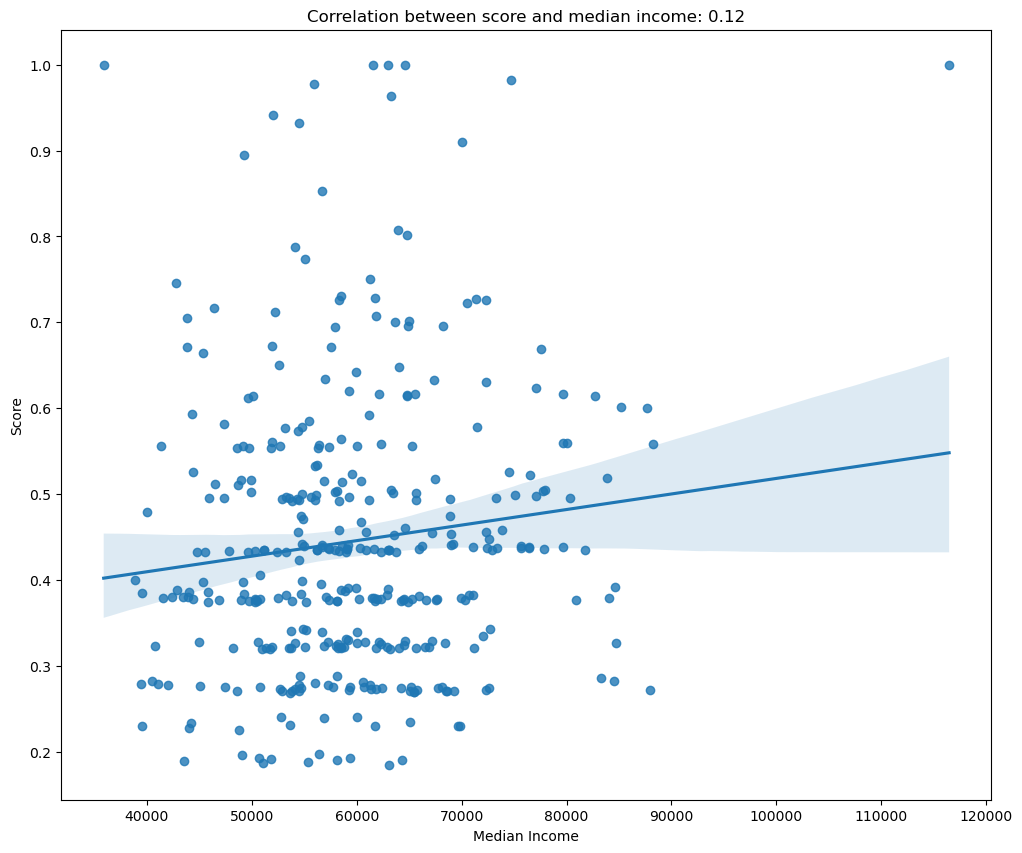

In [53]:
final_score_df = pd.read_sql("SELECT * FROM final_score", conn)
final_score_df['sa2_code'] = final_score_df['sa2_code'].astype(str)
incom['sa2_code'] = incom['sa2_code'].astype(str)
combined_data = final_score_df.merge(incom[['sa2_code', 'median_income']], on='sa2_code')
correlation = combined_data['score'].corr(combined_data['median_income'])

plt.figure(figsize=(12, 10))
sns.regplot(x='median_income', y='score', data=combined_data, ci=None)
plt.title(f'Correlation between score and median income: {correlation:.2f}')
plt.xlabel('Median Income')
plt.ylabel('Score')
plt.show()

## Map

In [42]:
sql_command = text("""
CREATE VIEW final_score_map AS
SELECT
    fs.sa2_code,
    fs.sa2_name,
    sa.geom,
    fs.score
FROM
    final_score fs
JOIN
    sa2 sa ON fs.sa2_code = sa.sa2_code;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM final_score_map ORDER BY score DESC; """)
query(conn, sql)

,sa2_code,sa2_name,geom,score
0,117031644,Sydney (North) - Millers Point,0106000020BB100000030000000103000000010000000E...,1.000000
1,125031486,Smithfield Industrial,0106000020BB10000001000000010300000001000000D6...,0.999999
2,117031645,Sydney (South) - Haymarket,0106000020BB10000001000000010300000001000000B1...,0.999992
3,127021521,Wetherill Park Industrial,0106000020BB1000000100000001030000000100000055...,0.999957
4,116031318,Prospect Reservoir,0106000020BB1000000100000001030000000100000066...,0.999579
...,...,...,...,...
360,127031730,Edmondson Park,0106000020BB100000010000000103000000010000007C...,0.190090
361,125011585,Berala,0106000020BB1000000100000001030000000100000081...,0.189122
362,102011035,Narara,0106000020BB1000000100000001030000000100000009...,0.188045
363,119031667,Penshurst,0106000020BB10000001000000010300000001000000A7...,0.186554


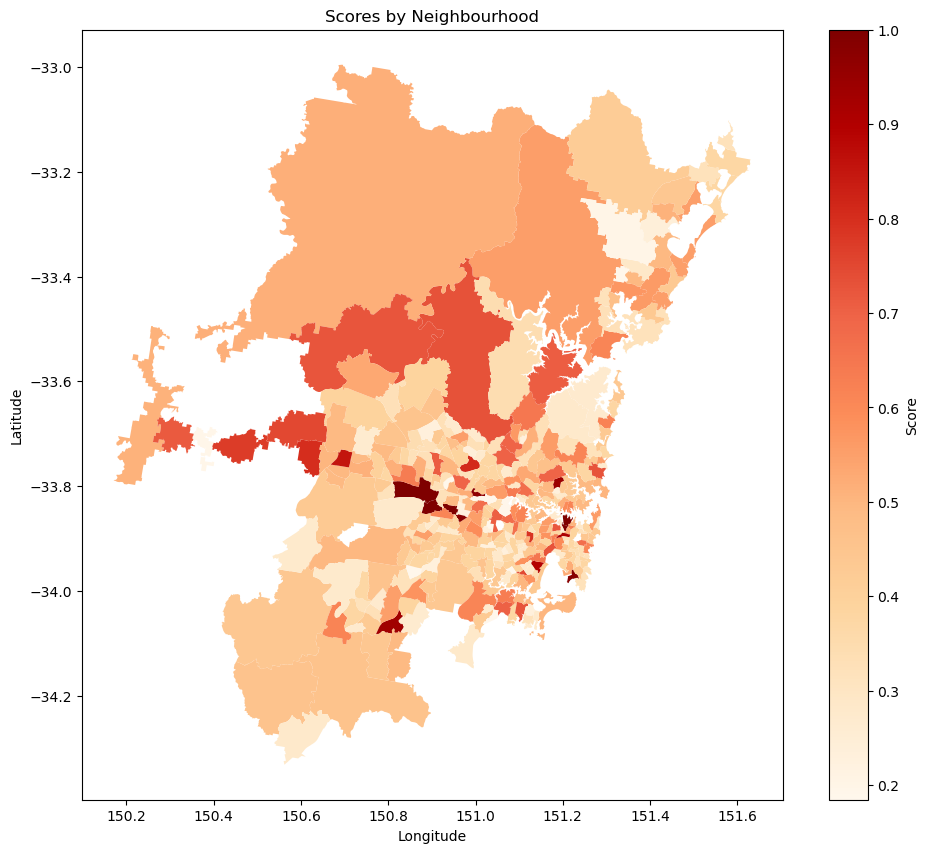

In [43]:
sa2_map = gpd.read_postgis("SELECT geom, score FROM final_score_map", conn, crs=4283)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sa2_map.plot(column='score', ax=ax, legend=True,
             legend_kwds={'label': "Score",
                          'orientation': "vertical"},
             cmap='OrRd')
ax.set_title('Scores by Neighbourhood')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Task 3

## Hospital z-score

In [44]:
# Data cleaning
hosp = pd.read_csv("hospitals.csv")
hosp.rename(columns = {'Name of Facility (consistent with State license where relevant)': 'facility_name', 'Provider Number': 'provider_number'}, inplace=True)
hosp.columns = [col.lower() for col in hosp.columns]
columns_to_keep = ['type', 'state', 'facility_name', 'provider_number', 'suburb', 'postcode']
hosp = hosp[columns_to_keep]
hosp = hosp[hosp['state'] == 'NSW']
hosp.dropna(inplace=True)
hosp

,type,state,facility_name,provider_number,suburb,postcode
7,PRIVATE,NSW,AESTHETIC DAY SURGERY,0896271A,KOGARAH,2217
12,PRIVATE,NSW,ALBURY DAY SURGERY,0657791J,ALBURY,2640
13,PUBLIC,NSW,ALBURY WODONGA HEALTH - ALBURY CAMPUS,0010560W,ALBURY,2640
15,PRIVATE,NSW,ALBURY WODONGA PRIVATE HOSPITAL,0016960X,ALBURY,2640
17,PRIVATE,NSW,ALEXANDRIA SPECIALIST DAY HOSPITAL,0027000Y,ALEXANDRIA,2015
...,...,...,...,...,...,...
1304,PUBLIC,NSW,WOY WOY PUBLIC HOSPITAL,0012650Y,WOY WOY,2256
1307,PUBLIC,NSW,WYALONG HOSPITAL,0012410T,WEST WYALONG,2671
1310,PUBLIC,NSW,WYONG PUBLIC HOSPITAL,0012770L,HAMLYN TERRACE,2259
1314,PUBLIC,NSW,YASS DISTRICT HOSPITAL,0012420L,YASS,2582


In [45]:
sql_commands = text("""DROP TABLE IF EXISTS hosp;
CREATE TABLE hosp (
    type VARCHAR(50),
    state VARCHAR(10),
    facility_name VARCHAR(150),
    provider_number VARCHAR(150),
    suburb VARCHAR(50),
    postcode VARCHAR(50)
);""")
conn.execute(sql_commands)
hosp.to_sql('hosp', conn, if_exists='append', index=False)
sql = text("""SELECT * FROM hosp;""")
query(conn, sql)

,type,state,facility_name,provider_number,suburb,postcode
0,PRIVATE,NSW,AESTHETIC DAY SURGERY,0896271A,KOGARAH,2217
1,PRIVATE,NSW,ALBURY DAY SURGERY,0657791J,ALBURY,2640
2,PUBLIC,NSW,ALBURY WODONGA HEALTH - ALBURY CAMPUS,0010560W,ALBURY,2640
3,PRIVATE,NSW,ALBURY WODONGA PRIVATE HOSPITAL,0016960X,ALBURY,2640
4,PRIVATE,NSW,ALEXANDRIA SPECIALIST DAY HOSPITAL,0027000Y,ALEXANDRIA,2015
...,...,...,...,...,...,...
410,PUBLIC,NSW,WOY WOY PUBLIC HOSPITAL,0012650Y,WOY WOY,2256
411,PUBLIC,NSW,WYALONG HOSPITAL,0012410T,WEST WYALONG,2671
412,PUBLIC,NSW,WYONG PUBLIC HOSPITAL,0012770L,HAMLYN TERRACE,2259
413,PUBLIC,NSW,YASS DISTRICT HOSPITAL,0012420L,YASS,2582


In [46]:
sql_command = text("""
CREATE OR REPLACE VIEW hospital_pollp_join AS
SELECT
    h.*,
    p.geom AS pollp_geom
FROM
    hosp h
JOIN
    pollp p
ON
    h.postcode = p.premises_post_code;

CREATE OR REPLACE VIEW hospital_sa2_join AS
SELECT
    h.*,
    sa2.sa2_code,
    sa2.sa2_name
FROM
    hospital_pollp_join h
JOIN
    sa2
ON
    ST_Contains(sa2.geom, h.pollp_geom);

CREATE OR REPLACE VIEW hospital_counts AS
SELECT
    sa2_code,
    sa2_name,
    COUNT(*) AS hospital_count
FROM
    hospital_sa2_join
GROUP BY
    sa2_code,sa2_name;

CREATE OR REPLACE VIEW hospital_z_score AS
SELECT
    h.sa2_code,
    h.sa2_name,
    h.hospital_count,
    (h.hospital_count - avg_stats.mean_hospital_count) / avg_stats.stddev_hospital_count AS z_hospital
FROM
    hospital_counts h,
    (
        SELECT
            AVG(hospital_count) AS mean_hospital_count,
            STDDEV(hospital_count) AS stddev_hospital_count
        FROM
            hospital_counts
    ) AS avg_stats;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM hospital_z_score ORDER BY z_hospital DESC; """)
query(conn, sql)

,sa2_code,sa2_name,hospital_count,z_hospital
0,117031644,Sydney (North) - Millers Point,704,12.812623
1,117031645,Sydney (South) - Haymarket,297,5.249151
2,121011684,Chatswood - East,75,1.123620
3,118021569,Randwick - North,64,0.919202
4,125041588,Pendle Hill - Girraween,63,0.900618
...,...,...,...,...
200,115041624,North Kellyville,1,-0.251557
201,128021535,Menai - Lucas Heights - Woronora,1,-0.251557
202,128021536,Oyster Bay - Como - Jannali,1,-0.251557
203,115031299,Bilpin - Colo - St Albans,1,-0.251557


## Beach z-score

In [47]:
# Data cleaning
beach = pd.read_csv("sydneybeaches.csv")
beach = beach.dropna()
beach['geom'] = gpd.points_from_xy(beach.Longitude, beach.Latitude)
beach['geom'] = beach['geom'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
columns_to_keep = ['BeachId', 'Council', 'Site', 'geom']
beach = beach[columns_to_keep]
beach = beach.drop_duplicates(subset=['Site'])
beach.columns = [col.lower() for col in beach.columns]
beach

,beachid,council,site,geom
0,25.0,Randwick Council,Clovelly Beach,POINT (151.267505 -33.914486)
58,26.0,Randwick Council,Coogee Beach,POINT (151.25817 -33.92076)
116,25.9,Randwick Council,Gordons Bay (East),POINT (151.264558 -33.915646)
160,29.0,Randwick Council,Little Bay Beach,POINT (151.25149 -33.98012)
218,28.0,Randwick Council,Malabar Beach,POINT (151.252247 -33.96436)
276,27.0,Randwick Council,Maroubra Beach,POINT (151.25718 -33.94879)
334,27.4,Randwick Council,South Maroubra Beach,POINT (151.257175 -33.951615)
392,27.3,Randwick Council,South Maroubra Rockpool,POINT (151.2582 -33.95354)
428,22.0,Waverley Council,Bondi Beach,POINT (151.27761 -33.89151)
486,24.0,Waverley Council,Bronte Beach,POINT (151.268622 -33.903069)


In [48]:
sql_commands = text("""
DROP TABLE IF EXISTS beach CASCADE;
CREATE TABLE beach (
    beachid FLOAT,
    council VARCHAR(100),
    site VARCHAR(100),
    geom GEOMETRY(POINT, 4283)
);
""")
conn.execute(sql_commands)
beach.to_sql("beach", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
sql = text("""SELECT * FROM beach;""")
query(conn, sql)

,beachid,council,site,geom
0,25.0,Randwick Council,Clovelly Beach,0101000020BB1000008750A5668FE862402E5393E00DF5...
1,26.0,Randwick Council,Coogee Beach,0101000020BB100000DE59BBED42E8624084BBB376DBF5...
2,25.9,Randwick Council,Gordons Bay (East),0101000020BB100000A5BC564277E862404B5B5CE333F5...
3,29.0,Randwick Council,Little Bay Beach,0101000020BB100000ACA8C1340CE86240E813799274FD...
4,28.0,Randwick Council,Malabar Beach,0101000020BB10000074F04C6812E8624008C9022670FB...
5,27.0,Randwick Council,Maroubra Beach,0101000020BB100000EE258DD13AE86240CC6262F371F9...
6,27.4,Randwick Council,South Maroubra Beach,0101000020BB10000029CB10C73AE8624007B13385CEF9...
7,27.3,Randwick Council,South Maroubra Rockpool,0101000020BB100000787AA52C43E86240C3B645990DFA...
8,22.0,Waverley Council,Bondi Beach,0101000020BB1000005DE15D2EE2E862404A07EBFF1CF2...
9,24.0,Waverley Council,Bronte Beach,0101000020BB1000008E1F2A8D98E862400684D6C397F3...


In [49]:
sql_command = text("""
CREATE OR REPLACE VIEW beach_with_sa2 AS
SELECT
    b.beachid,
    b.council,
    b.site,
    b.geom,
    sa.sa2_code,
    sa.sa2_name
FROM
    beach b
JOIN
    sa2 sa
ON
    ST_Intersects(sa.geom, b.geom);


CREATE OR REPLACE VIEW beach_count_per_sa2 AS
SELECT
    sa2_code,
    sa2_name,
    COUNT(beachid) AS beach_count
FROM
    beach_with_sa2
GROUP BY
    sa2_code,sa2_name;


CREATE OR REPLACE VIEW beach_stats AS
SELECT
    AVG(beach_count) AS mean_beach_count,
    STDDEV(beach_count) AS stddev_beach_count
FROM
    beach_count_per_sa2;


CREATE OR REPLACE VIEW beach_z_score AS
SELECT
    bc.sa2_code,
    bc.sa2_name,
    bc.beach_count,
    (bc.beach_count - stats.mean_beach_count) / stats.stddev_beach_count AS z_beach
FROM
    beach_count_per_sa2 bc,
    beach_stats stats;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM beach_z_score; """)
query(conn, sql)

,sa2_code,sa2_name,beach_count,z_beach
0,118011339,Bondi - Tamarama - Bronte,2,1.095445
1,118011340,Bondi Beach - North Bondi,1,-0.730297
2,118021567,Maroubra - South,1,-0.730297
3,118021651,Coogee - Clovelly,2,1.095445
4,118021652,Malabar - La Perouse,1,-0.730297


## Score

In [50]:
sql_command = text("""
CREATE OR REPLACE VIEW final_score_with_hospital_and_beach AS
SELECT
    fs.sa2_code,
    fs.sa2_name,
    fs.z_business,
    fs.z_stops,
    fs.z_schools,
    fs.z_polls,
    COALESCE(hs.z_hospital, 0) AS z_hospital,
    COALESCE(bs.z_beach, 0) AS z_beach,
    (fs.z_business + fs.z_stops + fs.z_schools + fs.z_polls + COALESCE(hs.z_hospital, 0) + COALESCE(bs.z_beach, 0)) AS z_sum,
    1 / (1 + EXP(-(fs.z_business + fs.z_stops + fs.z_schools + fs.z_polls + COALESCE(hs.z_hospital, 0) + COALESCE(bs.z_beach, 0)))) AS score
FROM
    final_score fs
LEFT JOIN
    hospital_z_score hs ON fs.sa2_code = hs.sa2_code
LEFT JOIN
    beach_z_score bs ON fs.sa2_code = bs.sa2_code;
""")
conn.execute(sql_command)
sql = text("""SELECT * FROM final_score_with_hospital_and_beach ORDER BY score DESC; """)
query(conn, sql)

,sa2_code,sa2_name,z_business,z_stops,z_schools,z_polls,z_hospital,z_beach,z_sum,score
0,117031644,Sydney (North) - Millers Point,0.495437,8.535131,-0.071786,14.476684,12.812623,0.000000,36.248089,1.000000
1,117031645,Sydney (South) - Haymarket,-0.043023,6.354447,-0.074342,5.504492,5.249151,0.000000,16.990724,1.000000
2,125031486,Smithfield Industrial,13.245117,0.000000,0.967405,0.000000,0.000000,0.000000,14.212522,0.999999
3,127021521,Wetherill Park Industrial,9.900155,0.000000,0.948649,-0.800291,0.000000,0.000000,10.048512,0.999957
4,116031318,Prospect Reservoir,7.771543,0.000000,0.000000,0.000000,0.000000,0.000000,7.771543,0.999579
...,...,...,...,...,...,...,...,...,...,...
360,102011035,Narara,-0.127584,-0.460188,-0.074698,-0.800291,-0.214390,0.000000,-1.677151,0.157473
361,125041718,Parramatta - South,-0.108139,-0.460188,-0.076077,-0.800291,-0.232973,0.000000,-1.677669,0.157404
362,125041719,Rosehill - Harris Park,-0.101788,-0.460188,-0.075191,-0.800291,-0.251557,0.000000,-1.689015,0.155905
363,118021652,Malabar - La Perouse,-0.112903,0.000000,-0.075866,-0.557800,-0.232973,-0.730297,-1.709838,0.153185


In [51]:
conn.close()
db.dispose()